In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# ---------------------------------------------------------
# ADIM 1: VERİ KEŞFİ VE ÖN İŞLEME (EDA)
# ---------------------------------------------------------

In [27]:
# Veri setini yükleme
df = pd.read_csv('/kaggle/input/synthetic-financial-fraud-dataset/synthetic_fraud_dataset.csv')

In [8]:
print("-Veri Seti İlk 5 Satır-")
print(df.head())

-Veri Seti İlk 5 Satır-
   transaction_id  user_id       amount transaction_type merchant_category  \
0            9608      363  4922.587542              ATM            Travel   
1             456      692    48.018303               QR              Food   
2            4747      587   136.881960           Online            Travel   
3            6934      445    80.534719              POS          Clothing   
4            1646      729   120.041158           Online           Grocery   

  country  hour  device_risk_score  ip_risk_score  is_fraud  
0      TR    12           0.992347       0.947908         1  
1      US    21           0.168571       0.224057         0  
2      TR    14           0.296127       0.125058         0  
3      TR    23           0.124801       0.159243         0  
4      FR    16           0.098129       0.027542         0  


In [9]:
print("\n- Veri Seti Genel Bilgileri -")
print(df.info())


- Veri Seti Genel Bilgileri -
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   transaction_id     10000 non-null  int64  
 1   user_id            10000 non-null  int64  
 2   amount             10000 non-null  float64
 3   transaction_type   10000 non-null  object 
 4   merchant_category  10000 non-null  object 
 5   country            10000 non-null  object 
 6   hour               10000 non-null  int64  
 7   device_risk_score  10000 non-null  float64
 8   ip_risk_score      10000 non-null  float64
 9   is_fraud           10000 non-null  int64  
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB
None


In [13]:
# Eksik verileri kontrol etme
print("\n-Eksik Veri Sayıları -")
print(df.isnull().sum())


-Eksik Veri Sayıları -
transaction_id       0
user_id              0
amount               0
transaction_type     0
merchant_category    0
country              0
hour                 0
device_risk_score    0
ip_risk_score        0
is_fraud             0
dtype: int64


In [14]:
# Aykırı değer analizi ve Sınıf Dağılımı (Fraud vs Normal)
print("\n- Sınıf Dağılımı (0: Normal, 1: Fraud) -")
print(df['is_fraud'].value_counts())


- Sınıf Dağılımı (0: Normal, 1: Fraud) -
is_fraud
0    9500
1     500
Name: count, dtype: int64


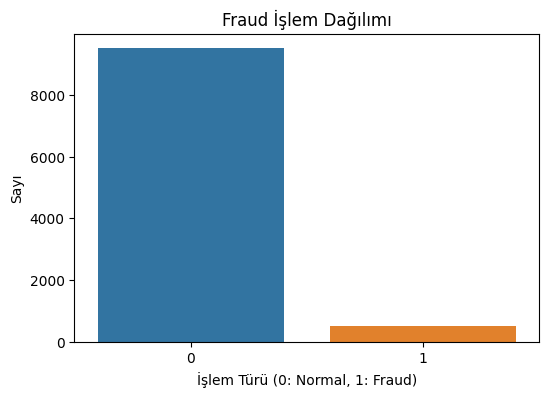

In [15]:
# Görselleştirme 1: Hedef Değişken Dağılımı
plt.figure(figsize=(6, 4))
sns.countplot(x='is_fraud', data=df)
plt.title('Fraud İşlem Dağılımı')
plt.xlabel('İşlem Türü (0: Normal, 1: Fraud)')
plt.ylabel('Sayı')
plt.show()

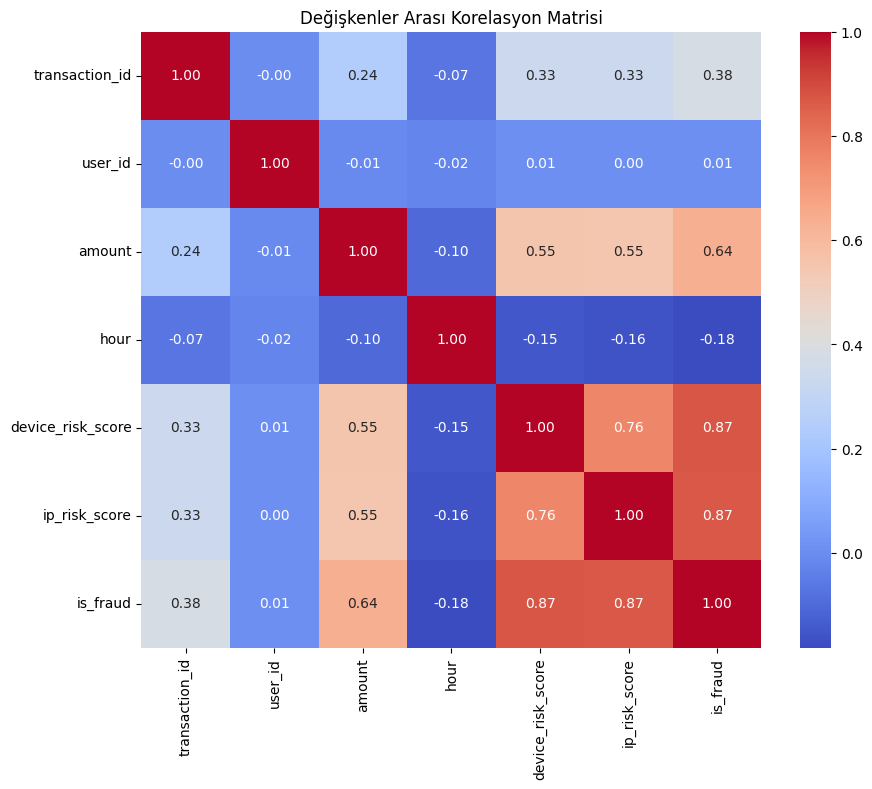

In [16]:
# Görselleştirme 2: Korelasyon Matrisi
# Sadece sayısal sütunları seçerek korelasyona bakıyoruz
plt.figure(figsize=(10, 8))
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Değişkenler Arası Korelasyon Matrisi')
plt.show()

In [39]:
# Ön İşleme: Gereksiz sütunların çıkarılması (ID bilgileri)
df_clean = df.drop(['transaction_id', 'user_id'], axis=1)
df_clean

,amount,transaction_type,merchant_category,country,hour,device_risk_score,ip_risk_score,is_fraud
0,4922.587542,ATM,Travel,TR,12,0.992347,0.947908,1
1,48.018303,QR,Food,US,21,0.168571,0.224057,0
2,136.881960,Online,Travel,TR,14,0.296127,0.125058,0
3,80.534719,POS,Clothing,TR,23,0.124801,0.159243,0
4,120.041158,Online,Grocery,FR,16,0.098129,0.027542,0
...,...,...,...,...,...,...,...,...
9995,58.366442,POS,Clothing,DE,12,0.066366,0.086344,0
9996,139.502160,POS,Travel,DE,13,0.119014,0.285680,0
9997,71.012122,Online,Travel,TR,8,0.119204,0.262262,0
9998,21.031405,QR,Grocery,UK,12,0.027088,0.295243,0


In [42]:
# Kategorik Değişkenlerin Dönüştürülmesi (One-Hot Encoding)
# Modelin anlayabilmesi için metin verileri sayıya çevrilir
categorical_cols = ['transaction_type', 'merchant_category', 'country']
df_encoded = pd.get_dummies(df_clean, columns=categorical_cols, drop_first=True)

# ---------------------------------------------------------
# ADIM 2: MODEL KURULUMU
# ---------------------------------------------------------

In [43]:
# Bağımlı (y) ve Bağımsız (X) değişkenlerin ayrılması
X = df_encoded.drop('is_fraud', axis=1)
y = df_encoded['is_fraud']

In [45]:
# Eğitim ve Test setlerinin ayrılması (%80 Eğitim, %20 Test)
# stratify=y parametresi, fraud oranının eğitim ve test setinde dengeli dağılmasını sağlar
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [50]:
# Model Seçimi: Random Forest Classifier
print("\n- Model Eğitiliyor... -")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
print("Model Eğitimi Tamamlandı.")


- Model Eğitiliyor... -
Model Eğitimi Tamamlandı.


# ---------------------------------------------------------
# ADIM 3: DEĞERLENDİRME
# ---------------------------------------------------------

In [47]:
# Test seti üzerinde tahmin yapma
y_pred = rf_model.predict(X_test)

In [49]:
# Başarı Metrikleri
print("\n- Model Performans Değerleri -")
print(f"Accuracy Score (Doğruluk): {accuracy_score(y_test, y_pred)}")


--- Model Performans Değerleri ---
Accuracy Score (Doğruluk): 1.0


In [51]:
print("\n- Confusion Matrix (Karmaşıklık Matrisi) -")
print(confusion_matrix(y_test, y_pred))


- Confusion Matrix (Karmaşıklık Matrisi) -
[[1900    0]
 [   0  100]]


In [53]:
print("\n- Sınıflandırma Raporu -")
print(classification_report(y_test, y_pred))


- Sınıflandırma Raporu -
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1900
           1       1.00      1.00      1.00       100

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



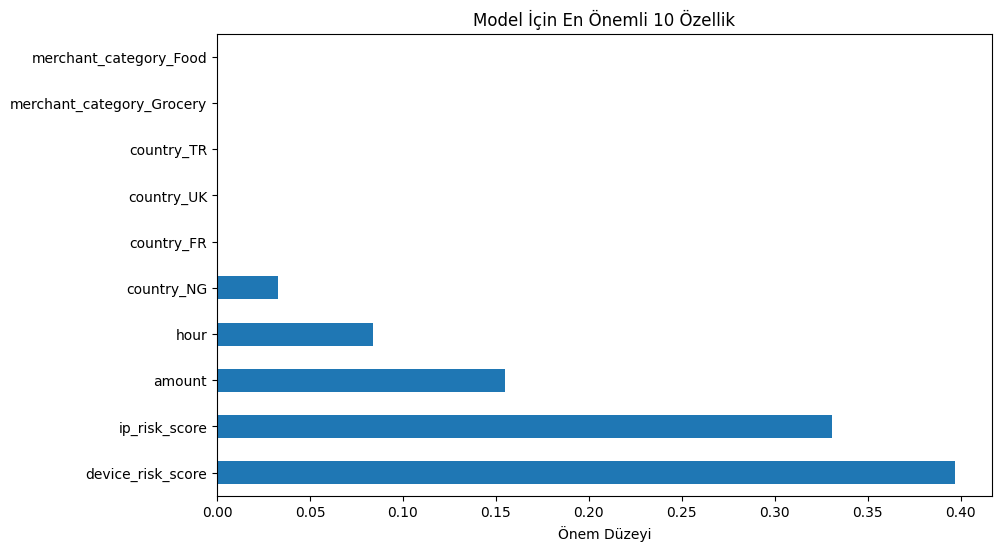

In [54]:
# Özellik Önem Düzeyleri (Feature Importance) Görselleştirmesi
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
plt.figure(figsize=(10, 6))
feature_importances.nlargest(10).plot(kind='barh')
plt.title('Model İçin En Önemli 10 Özellik')
plt.xlabel('Önem Düzeyi')
plt.show()